In [ ]:
import h2o
from h2o.estimators import H2OExtendedIsolationForestEstimator
import numpy as np
import pandas as pd
import os
import pickle
import optuna
import math
import matplotlib.pyplot as plt

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
###Prueba arquitectura
# Inicializar H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.10+11-LTS-240, mixed mode, sharing)
  Starting server from C:\Users\User\AppData\Local\Programs\Python\Python39\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\User\AppData\Local\Temp\tmpmsh2kuhu
  JVM stdout: C:\Users\User\AppData\Local\Temp\tmpmsh2kuhu\h2o_Abel_started_from_python.out
  JVM stderr: C:\Users\User\AppData\Local\Temp\tmpmsh2kuhu\h2o_Abel_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Guayaquil
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 year and 16 days
H2O_cluster_name:,H2O_from_python_Abel_iomwqn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.984 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [5]:
data = h2o.import_file('CROSS_0/Procesado_MatrizZ/Entrenamiento.csv')
data=data.drop(72)
data_val=  h2o.import_file('CROSS_0\Procesado_MatrizZ\Validar.csv')
data_val=data_val.drop(72)
data_test_1=  h2o.import_file('CROSS_0\Procesado_MatrizZ\Fallo1.csv')
data_test_1=data_test_1.drop(72)
data_test_2=  h2o.import_file('CROSS_0\Procesado_MatrizZ\Fallo2.csv')
data_test_2=data_test_2.drop(72)
data_test_3=  h2o.import_file('CROSS_0\Procesado_MatrizZ\Fallo3.csv')
data_test_3=data_test_3.drop(72)
data_test_4=  h2o.import_file('CROSS_0\Procesado_MatrizZ\Fallo4.csv')
data_test_4=data_test_4.drop(72)
data_test_h=  h2o.import_file('CROSS_0\Procesado_MatrizZ\Testeo_Sanos.csv')
data_test_h=data_test_h.drop(72)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## Threshold optimization 

In [ ]:
# Define an objective function to be maximized.

def objective(trial):

    model = H2OExtendedIsolationForestEstimator(ntrees=trial.suggest_int('ntrees', 100, 800), seed=1627680000000000000,extension_level=trial.suggest_int('extension_level', 0, 71), sample_size=trial.suggest_int('sample_size', 256, 1060))
    model.train(training_frame=data)
    # Train Extended Isolation Forest
    predictions_training = model.predict(data)
    anomaly_score_training = predictions_training["anomaly_score"].as_data_frame()

    predictions_val = model.predict(data_val)
    anomaly_score_val = predictions_val["anomaly_score"].as_data_frame()
    anomaly_score_total = pd.concat([anomaly_score_training, anomaly_score_val], ignore_index=True)

    # Divide el dataframe en grupos de 160 muestras
    group_size = 160
    groups = [anomaly_score_total.iloc[i:i+group_size] for i in range(0, len(anomaly_score_total), group_size)]

    # Calcula la mediana para cada grupo
    group_medians = [group.median().values[0] for group in groups]

    # Calcula la mediana para cada grupo
    group_medians = [group.median().values[0] for group in groups]

     # Calcula la media más tres desviaciones estándar de las medianas
    media_medianas = np.mean(group_medians)
    desviacion_estandar_medianas = np.std(group_medians)
    accuracy = media_medianas + 3 * desviacion_estandar_medianas

    # media = np.mean(anomaly_score_total)
    # desviacion_estandar = np.std(anomaly_score_total)

    # # Calcula la media más tres desviaciones estándar
    # accuracy = media + 3 * desviacion_estandar
    
    return accuracy

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='minimize', storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
        study_name="EIF_FINAL_2")
study.optimize(objective, n_trials=100)

In [9]:
#Trial 143 finished with value: 0.5848613826055343 and parameters: {'ntrees': 306, 'extension_level': 46, 'sample_size': 32}. Best is trial 143 with value: 0.5848613826055343.
from optuna.trial import TrialState
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
treshold = trial.value
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  25
  Number of pruned trials:  0
  Number of complete trials:  24
Best trial:
  Value:  0.47727829140683525
  Params: 
    extension_level: 53
    ntrees: 174
    sample_size: 882


## Algorithm training 

In [6]:
model = H2OExtendedIsolationForestEstimator(ntrees=226, seed=31415926535,extension_level=71, sample_size=891)#, ignored_columns=columnas_ignoradas_2
model.train(training_frame=data)

extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%


,number_of_trees,size_of_subsample,extension_level,seed,number_of_trained_trees,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves,min_isolated_point,max_isolated_point,mean_isolated_point,min_not_isolated_point,max_not_isolated_point,mean_not_isolated_point,min_zero_splits,max_zero_splits,mean_zero_splits
,174,882,53,31415926535.0000000,174.0,9.0,9.0,9.0,25.0,213.0,112.89655,5.0,72.0,33.62644,810.0,877.0,848.37354,6.0,70.0,34.04023


In [7]:
# Realizar predicciones
predictions = model.predict(data)
anomaly_score = predictions["anomaly_score"]
print(anomaly_score.max())
count_above_threshold = (anomaly_score > treshold).sum()
count_above_threshold

extendedisolationforest prediction progress: |

███████████████████████████████████| (done) 100%
0.5155791396958918


13.0

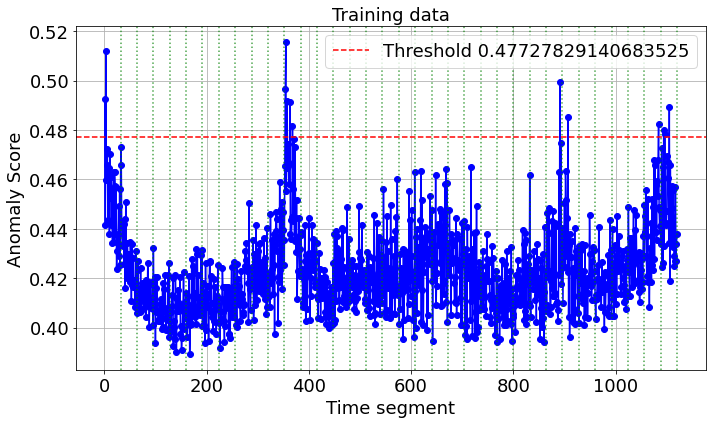

Número de valores de anomaly_score que superan 0.47727829140683525: 13


In [8]:
import matplotlib.pyplot as plt

# Supongamos que tienes un H2OFrame llamado 'predictions_testeo' con 'timestamp' y 'anomaly_score' como columnas

# Convertir el H2OFrame a un DataFrame de Pandas para manipulación y visualización
predictions_df = predictions.as_data_frame()
threshold_value=treshold
# Crear un gráfico de los valores de anomaly_score en el tiempo
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(predictions_df) + 1), predictions_df['anomaly_score'], marker='o', linestyle='-', color='b')
plt.axhline(y=treshold, color='r', linestyle='--', label='Threshold treshold')

plt.title('Training data', fontsize=18)
plt.xlabel('Time segment', fontsize=18)
plt.ylabel('Anomaly Score', fontsize=18)
# Aumentar el tamaño de los números en los ejes x e y
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.legend(fontsize=18)
# Agregar líneas verticales punteadas cada 9 números de puntos
for i in range(32, len(predictions_df) + 1, 32):
    plt.axvline(x=i, color='g', linestyle=':', alpha=0.7)  # Línea vertical verde punteada
plt.tight_layout()
plt.show()

# Contar cuántos valores de anomaly_score superan un umbral específico
umbral = treshold
count_above_umbral = (predictions_df['anomaly_score'] > umbral).sum()
print(f"Número de valores de anomaly_score que superan {umbral}: {count_above_umbral}")

0.47727829140683525


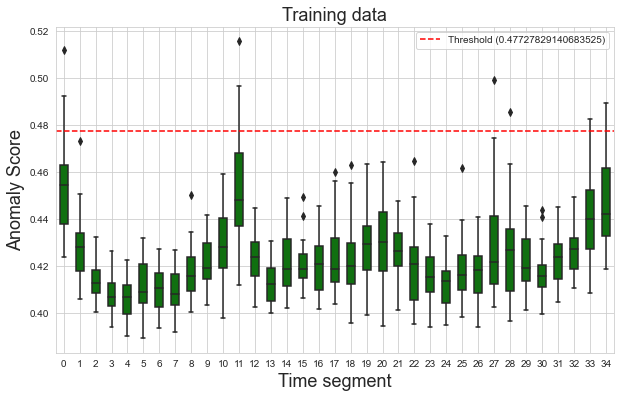

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tienes tu DataFrame df y has agregado la columna 'grupo' como en el código original
df = predictions_df
df['grupo'] = df.index // 32
# Configura el estilo de Seaborn con fondo blanco
sns.set_style("whitegrid")

# Crea el gráfico de boxplot con Seaborn y personaliza los colores
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='grupo', y='anomaly_score', color='green', width=0.5)

# Calcula la mediana más alta y establece un umbral
#mediana_maxima = df.groupby('grupo')['anomaly_score'].median().max()
#umbral = 1 * mediana_maxima  # Puedes ajustar el factor multiplicativo según tus necesidades
umbral = treshold
print(umbral)
# Agrega una línea horizontal para representar el umbral
plt.axhline(y=treshold, color='red', linestyle='--', label=f'Threshold (treshold)')

plt.title('Training data', fontsize=18)
plt.xlabel('Time segment', fontsize=18)
plt.ylabel('Anomaly Score', fontsize=18)
# Aumentar el tamaño de los números en los ejes x e y
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.legend(fontsize=10)
#ax.set_xticklabels([])
# # Personaliza las etiquetas del eje X para mostrar solo ciertos valores
# group_labels = [10, 20, 30, 40, 50]
# ax.set_xticks(group_labels)  # Establece las ubicaciones de las etiquetas
# ax.set_xticklabels([str(label) for label in group_labels])  # Establece las etiquetas como cadenas



In [15]:
predictions_val = model.predict(data_val)
anomaly_score_val = predictions_val["anomaly_score"]
print(anomaly_score_val.max())
# Contar cuántos valores de anomaly_score superan 0.49998176451164417
count_above_threshold= (anomaly_score_val > treshold).sum()
count_above_threshold

extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
0.5712244213181474


89.0

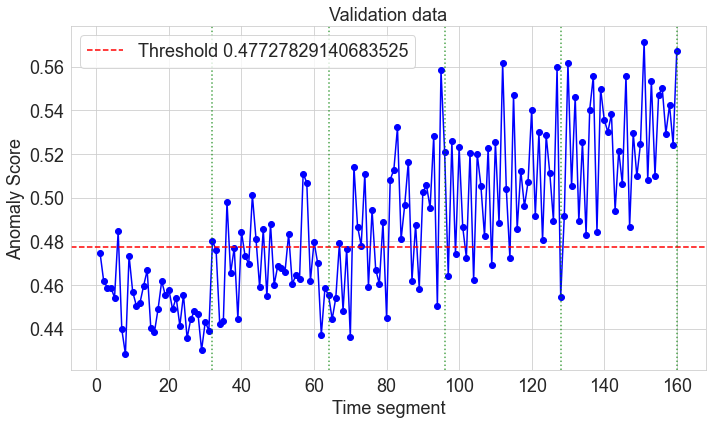

Número de valores de anomaly_score que superan 0.47727829140683525: 89


In [16]:
import matplotlib.pyplot as plt

# Supongamos que tienes un H2OFrame llamado 'predictions_testeo' con 'timestamp' y 'anomaly_score' como columnas

# Convertir el H2OFrame a un DataFrame de Pandas para manipulación y visualización
predictions_val_df = predictions_val.as_data_frame()
threshold_value=treshold
# Crear un gráfico de los valores de anomaly_score en el tiempo
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(predictions_val_df) + 1), predictions_val_df['anomaly_score'], marker='o', linestyle='-', color='b')
plt.axhline(y=treshold, color='r', linestyle='--', label='Threshold treshold')

plt.title('Validation data', fontsize=18)
plt.xlabel('Time segment', fontsize=18)
plt.ylabel('Anomaly Score', fontsize=18)
# Aumentar el tamaño de los números en los ejes x e y
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.legend(fontsize=18)
# Agregar líneas verticales punteadas cada 9 números de puntos
for i in range(32, len(predictions_val_df) + 1, 32):
    plt.axvline(x=i, color='g', linestyle=':', alpha=0.7)  # Línea vertical verde punteada
plt.tight_layout()
plt.show()

# Contar cuántos valores de anomaly_score superan un umbral específico
umbral = treshold
count_above_umbral = (predictions_val_df['anomaly_score'] > umbral).sum()
print(f"Número de valores de anomaly_score que superan {umbral}: {count_above_umbral}")

0.47727829140683525


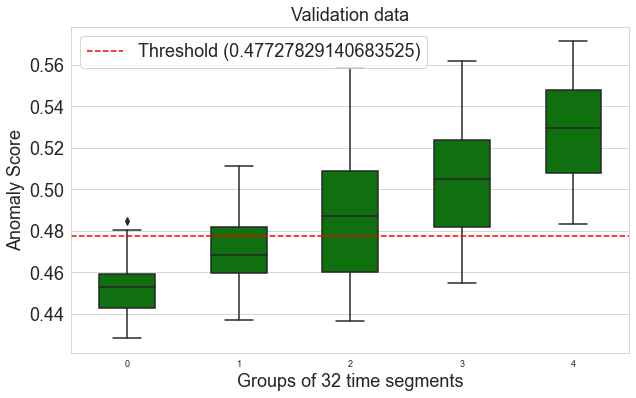

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tienes tu DataFrame df y has agregado la columna 'grupo' como en el código original
df = predictions_val_df
df['grupo'] = df.index // 32
# Configura el estilo de Seaborn con fondo blanco
sns.set_style("whitegrid")

# Crea el gráfico de boxplot con Seaborn y personaliza los colores
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='grupo', y='anomaly_score', color='green', width=0.5)

# Calcula la mediana más alta y establece un umbral
#mediana_maxima = df.groupby('grupo')['anomaly_score'].median().max()
#umbral = 1 * mediana_maxima  # Puedes ajustar el factor multiplicativo según tus necesidades
umbral = treshold
print(umbral)
# Agrega una línea horizontal para representar el umbral
plt.axhline(y=treshold, color='red', linestyle='--', label=f'Threshold (treshold)')
#ax.set_xticklabels([])
# # Personaliza las etiquetas del eje X para mostrar solo ciertos valores
# group_labels = [10, 20, 30, 40, 50]
# ax.set_xticks(group_labels)  # Establece las ubicaciones de las etiquetas
# ax.set_xticklabels([str(label) for label in group_labels])  # Establece las etiquetas como cadenas


# Agrega etiquetas y título
plt.title('Validation data', fontsize=18)
plt.xlabel('Groups of 32 time segments', fontsize=18)
plt.ylabel('Anomaly Score', fontsize=18)
plt.xticks(fontsize=9)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)  # Muestra la leyenda para la línea del umbral

# Muestra el gráfico
plt.show()

In [18]:
# Realizar predicciones
predictions_f1 = model.predict(data_test_1)
anomaly_score_f1 = predictions_f1["anomaly_score"]
print(anomaly_score_f1.min())
print(anomaly_score_f1.max())
count_above_threshold = (anomaly_score_f1 > treshold).sum()
count_above_threshold

extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
0.504473276788452
0.592431089636467


160.0

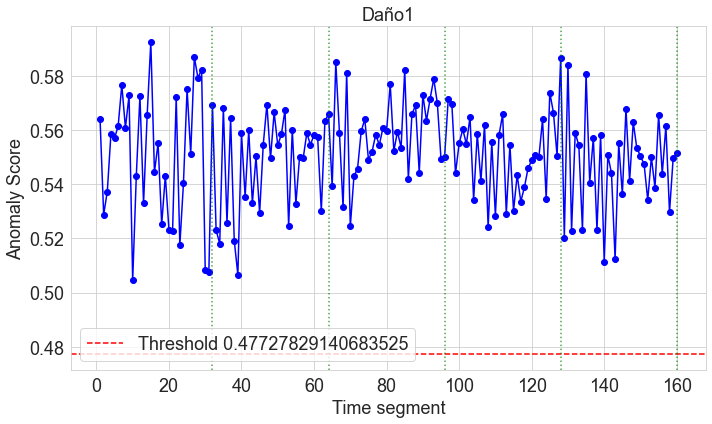

Número de valores de anomaly_score que superan 0.47727829140683525: 160


In [20]:
import matplotlib.pyplot as plt

# Supongamos que tienes un H2OFrame llamado 'predictions_testeo' con 'timestamp' y 'anomaly_score' como columnas

# Convertir el H2OFrame a un DataFrame de Pandas para manipulación y visualización
predictions_f1_df = predictions_f1.as_data_frame()
threshold_value=treshold
# Crear un gráfico de los valores de anomaly_score en el tiempo
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(predictions_f1_df) + 1), predictions_f1_df['anomaly_score'], marker='o', linestyle='-', color='b')
plt.axhline(y=treshold, color='r', linestyle='--', label='Threshold treshold')

plt.title('Daño1', fontsize=18)
plt.xlabel('Time segment', fontsize=18)
plt.ylabel('Anomaly Score', fontsize=18)
# Aumentar el tamaño de los números en los ejes x e y
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.legend(fontsize=18)
# Agregar líneas verticales punteadas cada 9 números de puntos
for i in range(32, len(predictions_f1_df) + 1, 32):
    plt.axvline(x=i, color='g', linestyle=':', alpha=0.7)  # Línea vertical verde punteada
plt.tight_layout()
plt.show()

# Contar cuántos valores de anomaly_score superan un umbral específico
umbral = treshold
count_above_umbral = (predictions_f1_df['anomaly_score'] > umbral).sum()
print(f"Número de valores de anomaly_score que superan {umbral}: {count_above_umbral}")

0.47727829140683525


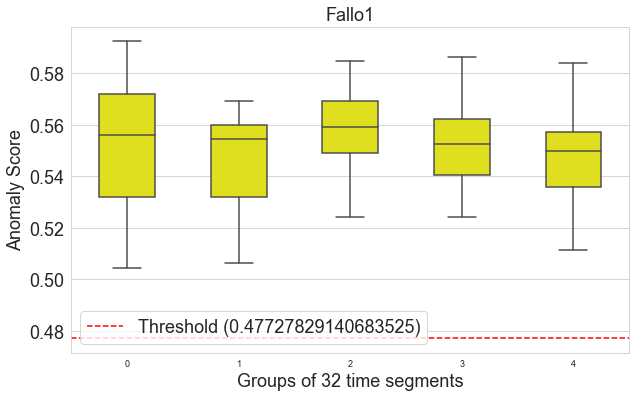

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tienes tu DataFrame df y has agregado la columna 'grupo' como en el código original
df = predictions_f1_df
df['grupo'] = df.index // 32
# Configura el estilo de Seaborn con fondo blanco
sns.set_style("whitegrid")

# Crea el gráfico de boxplot con Seaborn y personaliza los colores
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='grupo', y='anomaly_score', color='yellow', width=0.5)

umbral = treshold
print(umbral)
# Agrega una línea horizontal para representar el umbral
plt.axhline(y=treshold, color='red', linestyle='--', label=f'Threshold (treshold)')

# Agrega etiquetas y título
plt.title('Fallo1', fontsize=18)
plt.xlabel('Groups of 32 time segments', fontsize=18)
plt.ylabel('Anomaly Score', fontsize=18)
plt.xticks(fontsize=9)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)  # Muestra la leyenda para la línea del umbral

# Muestra el gráfico
plt.show()

In [22]:
# Realizar predicciones
predictions_f2 = model.predict(data_test_2)
anomaly_score_f2 = predictions_f2["anomaly_score"]
print(anomaly_score_f2.min())
print(anomaly_score_f2.max())
count_above_threshold = (anomaly_score_f2 > treshold).sum()
count_above_threshold

extendedisolationforest prediction progress: |

███████████████████████████████████| (done) 100%
0.47446246364239714
0.629844972783844


159.0

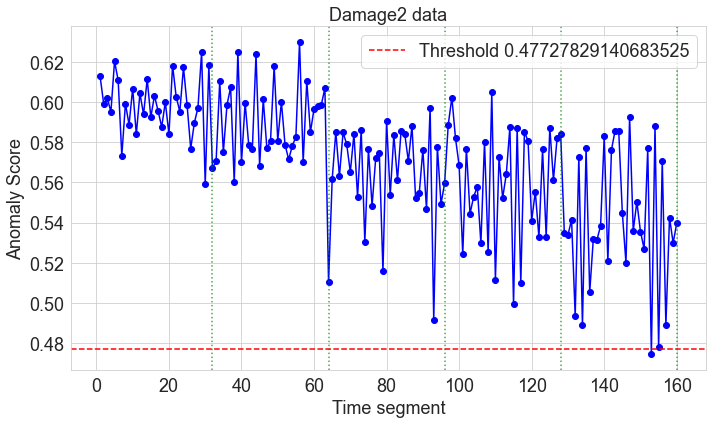

Número de valores de anomaly_score que superan 0.47727829140683525: 159


In [23]:
import matplotlib.pyplot as plt

# Supongamos que tienes un H2OFrame llamado 'predictions_testeo' con 'timestamp' y 'anomaly_score' como columnas

# Convertir el H2OFrame a un DataFrame de Pandas para manipulación y visualización
predictions_f2_df = predictions_f2.as_data_frame()
#threshold_value=0.4936568421525764
# Crear un gráfico de los valores de anomaly_score en el tiempo
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(predictions_f2_df) + 1), predictions_f2_df['anomaly_score'], marker='o', linestyle='-', color='b')
plt.axhline(y=treshold, color='r', linestyle='--', label='Threshold treshold')

plt.title('Damage2 data', fontsize=18)
plt.xlabel('Time segment', fontsize=18)
plt.ylabel('Anomaly Score', fontsize=18)
# Aumentar el tamaño de los números en los ejes x e y
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.legend(fontsize=18)
# Agregar líneas verticales punteadas cada 9 números de puntos
for i in range(32, len(predictions_f2_df) + 1, 32):
    plt.axvline(x=i, color='g', linestyle=':', alpha=0.7)  # Línea vertical verde punteada
plt.tight_layout()
plt.show()

# Contar cuántos valores de anomaly_score superan un umbral específico
umbral = treshold
count_above_umbral = (predictions_f2_df['anomaly_score'] > umbral).sum()
print(f"Número de valores de anomaly_score que superan {umbral}: {count_above_umbral}")

0.47727829140683525


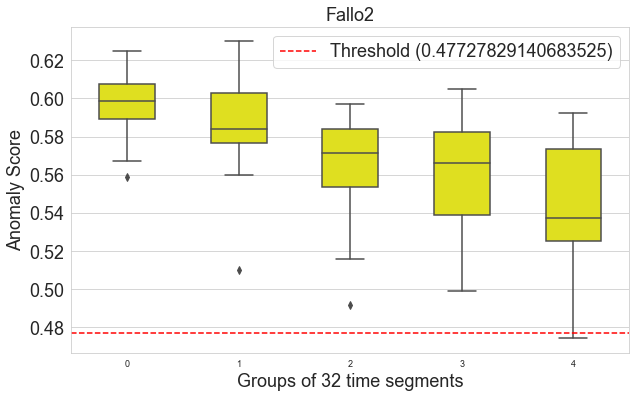

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tienes tu DataFrame df y has agregado la columna 'grupo' como en el código original
df = predictions_f2_df
df['grupo'] = df.index // 32
# Configura el estilo de Seaborn con fondo blanco
sns.set_style("whitegrid")

# Crea el gráfico de boxplot con Seaborn y personaliza los colores
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='grupo', y='anomaly_score', color='yellow', width=0.5)

umbral = treshold
print(umbral)
# Agrega una línea horizontal para representar el 
plt.axhline(y=treshold, color='red', linestyle='--', label=f'Threshold (treshold)')

# Agrega etiquetas y título
plt.title('Fallo2', fontsize=18)
plt.xlabel('Groups of 32 time segments', fontsize=18)
plt.ylabel('Anomaly Score', fontsize=18)
plt.xticks(fontsize=9)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)  # Muestra la leyenda para la línea del umbral

# Muestra el gráfico
plt.show()

In [9]:
# Realizar predicciones
predictions_f3 = model.predict(data_test_3)
anomaly_score_f3 = predictions_f3["anomaly_score"]
print(anomaly_score_f3.min())
print(anomaly_score_f3.max())
count_above_threshold = (anomaly_score_f3 > treshold).sum()
count_above_threshold

extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
0.7365056361415165
0.7805274543409644


160.0

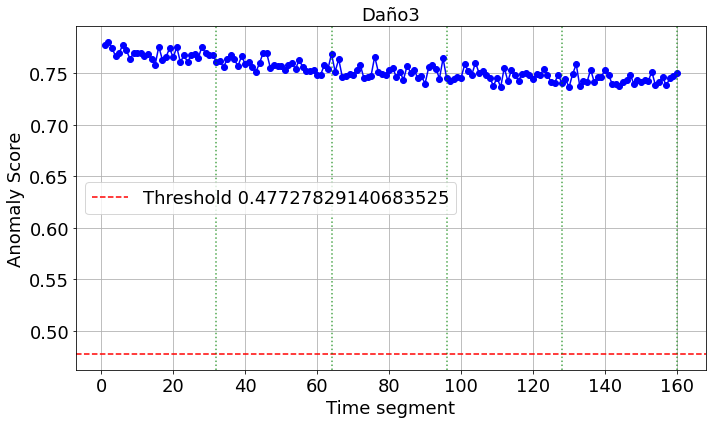

Número de valores de anomaly_score que superan 0.47727829140683525: 160


In [10]:


# Supongamos que tienes un H2OFrame llamado 'predictions_testeo' con 'timestamp' y 'anomaly_score' como columnas

# Convertir el H2OFrame a un DataFrame de Pandas para manipulación y visualización
predictions_f3_df = predictions_f3.as_data_frame()
#threshold_value=0.49998176451164417
# Crear un gráfico de los valores de anomaly_score en el tiempo
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(predictions_f3_df) + 1), predictions_f3_df['anomaly_score'], marker='o', linestyle='-', color='b')
plt.axhline(y=treshold, color='r', linestyle='--', label='Threshold treshold')

plt.title('Daño3', fontsize=18)
plt.xlabel('Time segment', fontsize=18)
plt.ylabel('Anomaly Score', fontsize=18)
# Aumentar el tamaño de los números en los ejes x e y
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.legend(fontsize=18)
# Agregar líneas verticales punteadas cada 9 números de puntos
for i in range(32, len(predictions_f3_df) + 1, 32):
    plt.axvline(x=i, color='g', linestyle=':', alpha=0.7)  # Línea vertical verde punteada
plt.tight_layout()
plt.show()

# Contar cuántos valores de anomaly_score superan un umbral específico
umbral = treshold
count_above_umbral = (predictions_f3_df['anomaly_score'] > umbral).sum()
print(f"Número de valores de anomaly_score que superan {umbral}: {count_above_umbral}")

In [40]:
# Guardar data_BASE como archivo CSV
data_BASE.to_csv('data_BASE.csv', index=False)

# Guardar data_anomaly como archivo CSV
data_anomaly.to_csv('data_anomaly.csv', index=False)

0.47727829140683525


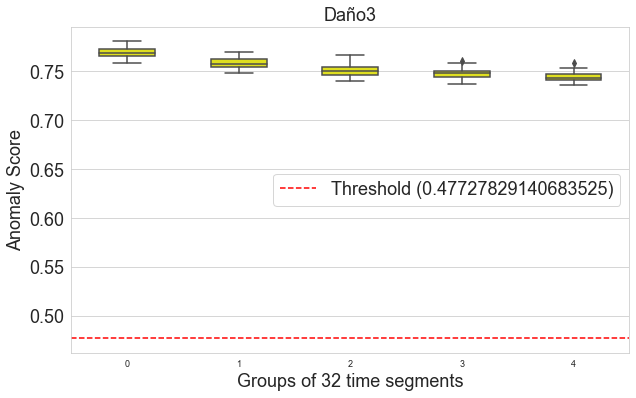

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tienes tu DataFrame df y has agregado la columna 'grupo' como en el código original
df = predictions_f3_df
df['grupo'] = df.index // 32
# Configura el estilo de Seaborn con fondo blanco
sns.set_style("whitegrid")

# Crea el gráfico de boxplot con Seaborn y personaliza los colores
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='grupo', y='anomaly_score', color='yellow', width=0.5)

umbral = treshold
print(umbral)
# Agrega una línea horizontal para representar el umbral
plt.axhline(y=treshold, color='red', linestyle='--', label=f'Threshold (treshold)')

# Agrega etiquetas y título
plt.title('Daño3', fontsize=18)
plt.xlabel('Groups of 32 time segments', fontsize=18)
plt.ylabel('Anomaly Score', fontsize=18)
plt.xticks(fontsize=9)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)  # Muestra la leyenda para la línea del umbral

# Muestra el gráfico
plt.show()

In [28]:
# Realizar predicciones
predictions_f4 = model.predict(data_test_4)
anomaly_score_f4 = predictions_f4["anomaly_score"]
print(anomaly_score_f4.min())
print(anomaly_score_f4.max())
count_above_threshold = (anomaly_score_f4 > treshold).sum()
count_above_threshold

extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
0.5027873692696732
0.7025745086091081


160.0

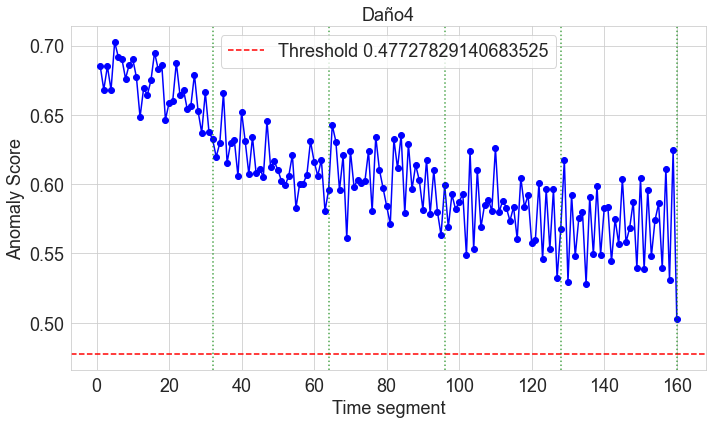

Número de valores de anomaly_score que superan 0.47727829140683525: 160


In [29]:
import matplotlib.pyplot as plt

# Supongamos que tienes un H2OFrame llamado 'predictions_testeo' con 'timestamp' y 'anomaly_score' como columnas

# Convertir el H2OFrame a un DataFrame de Pandas para manipulación y visualización
predictions_f4_df = predictions_f4.as_data_frame()
#threshold_value=0.49998176451164417
# Crear un gráfico de los valores de anomaly_score en el tiempo
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(predictions_f4_df) + 1), predictions_f4_df['anomaly_score'], marker='o', linestyle='-', color='b')
plt.axhline(y=treshold, color='r', linestyle='--', label='Threshold treshold')

plt.title('Daño4', fontsize=18)
plt.xlabel('Time segment', fontsize=18)
plt.ylabel('Anomaly Score', fontsize=18)
# Aumentar el tamaño de los números en los ejes x e y
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.legend(fontsize=18)
# Agregar líneas verticales punteadas cada 9 números de puntos
for i in range(32, len(predictions_f4_df) + 1, 32):
    plt.axvline(x=i, color='g', linestyle=':', alpha=0.7)  # Línea vertical verde punteada
plt.tight_layout()
plt.show()

# Contar cuántos valores de anomaly_score superan un umbral específico
umbral = treshold
count_above_umbral = (predictions_f4_df['anomaly_score'] > umbral).sum()
print(f"Número de valores de anomaly_score que superan {umbral}: {count_above_umbral}")

0.47727829140683525


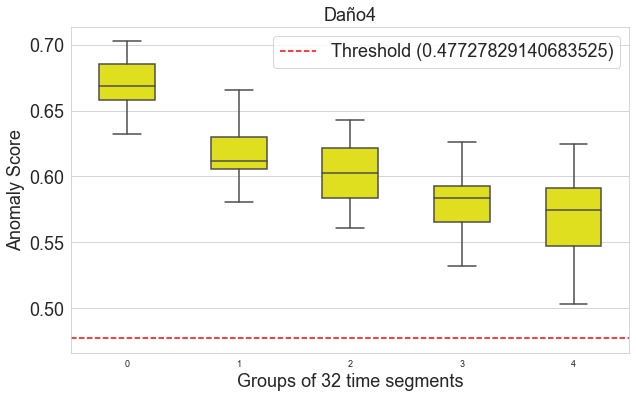

In [30]:

# Supongamos que tienes tu DataFrame df y has agregado la columna 'grupo' como en el código original
df = predictions_f4_df
df['grupo'] = df.index // 32
# Configura el estilo de Seaborn con fondo blanco
sns.set_style("whitegrid")

# Crea el gráfico de boxplot con Seaborn y personaliza los colores
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='grupo', y='anomaly_score', color='yellow', width=0.5)

umbral = treshold
print(umbral)
# Agrega una línea horizontal para representar el umbral
plt.axhline(y=treshold, color='red', linestyle='--', label=f'Threshold (treshold)')

# Agrega etiquetas y título
plt.title('Daño4', fontsize=18)
plt.xlabel('Groups of 32 time segments', fontsize=18)
plt.ylabel('Anomaly Score', fontsize=18)
plt.xticks(fontsize=9)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)  # Muestra la leyenda para la línea del umbral

# Muestra el gráfico
plt.show()

In [31]:
# Realizar predicciones
predictions_th = model.predict(data_test_h)
anomaly_score_th = predictions_th["anomaly_score"]
print(anomaly_score_th.max())
# Contar cuántos valores de anomaly_score superan 0.6
count_above_threshold= (anomaly_score_th > treshold).sum()
count_above_threshold

extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
0.5907442226967842


159.0

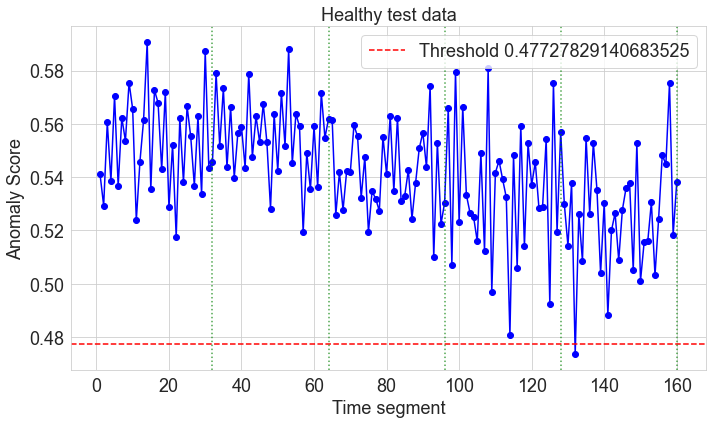

Número de valores de anomaly_score que superan 0.47727829140683525: 159


In [32]:
# Supongamos que tienes un H2OFrame llamado 'predictions_testeo' con 'timestamp' y 'anomaly_score' como columnas

# Convertir el H2OFrame a un DataFrame de Pandas para manipulación y visualización
predictions_th_df = predictions_th.as_data_frame()
#threshold_value=0.49998176451164417
# Crear un gráfico de los valores de anomaly_score en el tiempo
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(predictions_th_df) + 1), predictions_th_df['anomaly_score'], marker='o', linestyle='-', color='b')
plt.axhline(y=treshold, color='r', linestyle='--', label='Threshold treshold')

plt.title('Healthy test data', fontsize=18)
plt.xlabel('Time segment', fontsize=18)
plt.ylabel('Anomaly Score', fontsize=18)
# Aumentar el tamaño de los números en los ejes x e y
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.legend(fontsize=18)
# Agregar líneas verticales punteadas cada 9 números de puntos
for i in range(32, len(predictions_th_df) + 1, 32):
    plt.axvline(x=i, color='g', linestyle=':', alpha=0.7)  # Línea vertical verde punteada
plt.tight_layout()
plt.show()

# Contar cuántos valores de anomaly_score superan un umbral específico
umbral = treshold
count_above_umbral = (predictions_th_df['anomaly_score'] > umbral).sum()
print(f"Número de valores de anomaly_score que superan {umbral}: {count_above_umbral}")

0.47727829140683525


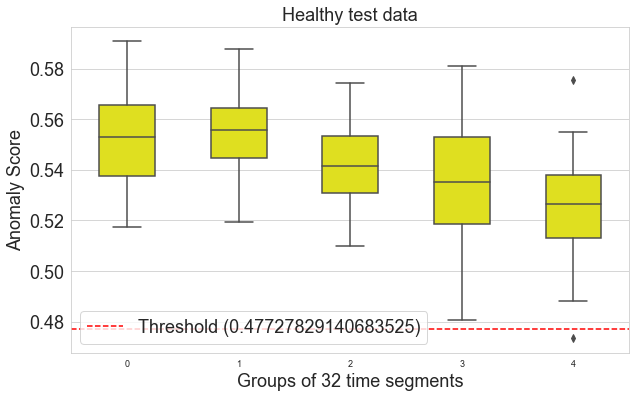

In [33]:


# Supongamos que tienes tu DataFrame df y has agregado la columna 'grupo' como en el código original
df = predictions_th_df
df['grupo'] = df.index // 32
# Configura el estilo de Seaborn con fondo blanco
sns.set_style("whitegrid")

# Crea el gráfico de boxplot con Seaborn y personaliza los colores
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='grupo', y='anomaly_score', color='yellow', width=0.5)

umbral = treshold
print(umbral)
# Agrega una línea horizontal para representar el umbral
plt.axhline(y=treshold, color='red', linestyle='--', label=f'Threshold (treshold)')

# Agrega etiquetas y título
plt.title('Healthy test data', fontsize=18)
plt.xlabel('Groups of 32 time segments', fontsize=18)
plt.ylabel('Anomaly Score', fontsize=18)
plt.xticks(fontsize=9)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)  # Muestra la leyenda para la línea del umbral

# Muestra el gráfico
plt.show()

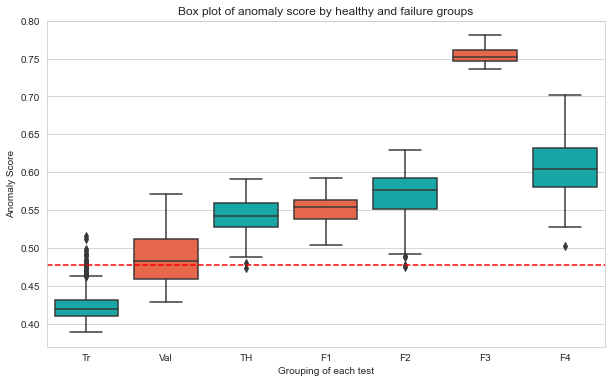

In [34]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que tienes una lista de DataFrames llamada dataframes_list
dataframes_list = [predictions_df, predictions_val_df, predictions_th_df, predictions_f1_df,predictions_f2_df,predictions_f3_df,predictions_f4_df]

# Concatenar los DataFrames en uno solo
df_combined = pd.concat(dataframes_list)

# Agregar una columna 'grupo' para etiquetar los datos según el DataFrame original
grupo_etiquetas = ['Tr', 'Val', 'TH', 'F1', 'F2', 'F3', 'F4']
df_combined['grupo'] = sum([[etiqueta] * len(df) for etiqueta, df in zip(grupo_etiquetas, dataframes_list)], [])

#df_combined['grupo'] = sum([[i] * len(df) for i, df in enumerate(dataframes_list)], [])

# Crear una lista de colores personalizados para cada grupo
colores_personalizados = ['c', '#FF5733']

# Trazar el boxplot con colores personalizados
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_combined, x='grupo', y='anomaly_score', palette=colores_personalizados)



plt.title('Box plot of anomaly score by healthy and failure groups')
plt.xlabel('Grouping of each test')
plt.ylabel('Anomaly Score')

# Dibujar una línea horizontal en el valor especificado
plt.axhline(y=umbral, color='r', linestyle='--', label=str(umbral))

plt.show()
